# Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
if 'MemWatcher' not in dir():
    from ipython_memwatcher import MemWatcher
    mw = MemWatcher()
    mw.start_watching_memory()

In [1] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 43.219 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.039 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 43.258 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 70.340 MiB RAM in 0.446s, peaked 8.180 MiB above current, total RAM usage 113.598 MiB


In [4]:
movies.dtypes

movie_id     int64
title       object
genres      object
dtype: object

In [4] used 0.203 MiB RAM in 0.008s, peaked 0.000 MiB above current, total RAM usage 113.801 MiB


In [5]:
lens = pd.merge(movies, ratings)

In [5] used 54.793 MiB RAM in 0.070s, peaked 23.266 MiB above current, total RAM usage 168.594 MiB


In [6]:
size_pandas = mw.measurements.memory_delta
size_pandas

54.79296875

In [6] used 0.082 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 168.676 MiB


In [7]:
# pandas also comes with its own tool for getting memory usage
print(lens.memory_usage())

Index             8001672
movie_id          8001672
title             8001672
genres            8001672
user_id           8001672
rating            8001672
unix_timestamp    8001672
dtype: int64
In [7] used 0.020 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 168.695 MiB


### Exercise

1) Why do you think that the size is the same for every column in the dataframe?

*Hint:* pandas stores the string columns in NumPy containers with 'object' dtype.

2) Provided how the `lens` DataFrame looks like:

In [8]:
lens.head()

,movie_id,title,genres,user_id,rating,unix_timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [8] used 0.000 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 168.695 MiB


In [9]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [9] used 24.594 MiB RAM in 0.116s, peaked 0.000 MiB above current, total RAM usage 193.289 MiB


Do you think this is all the memory that the DataFrame tables?

### Solution

In [10]:
# Use deep=True for including the size of the object types
print(lens.memory_usage(deep=True))

Index              8001672
movie_id           8001672
title             80347206
genres            71665151
user_id            8001672
rating             8001672
unix_timestamp     8001672
dtype: int64
In [10] used 0.000 MiB RAM in 0.130s, peaked 0.000 MiB above current, total RAM usage 193.289 MiB


In [11]:
# For a more realistic memory usage, we are going to use deep=True
size_pandas2 = lens.memory_usage(deep=True).sum() / 2**20.
size_pandas2

183.12522602081299

In [11] used 0.000 MiB RAM in 0.128s, peaked 0.000 MiB above current, total RAM usage 193.289 MiB


## Querying a pandas DataFrame

In [12]:
# Let's do a typical query in pandas and see how fast it can be
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

10 loops, best of 3: 33.1 ms per loop


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [12] used 0.328 MiB RAM in 1.405s, peaked 0.000 MiB above current, total RAM usage 193.617 MiB


In [13]:
# Store it for future reference
qtime_pandas = t.best

In [13] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 193.617 MiB


## Use a compressed in-memory container via `bcolz`

In [14]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'blosclz'
bcolz.defaults.cparams['clevel'] = 5
bcolz.defaults.cparams['shuffle'] = bcolz.SHUFFLE  # try with NOSHUFFLE and BITSHUFFLE as well
bcolz.set_nthreads(1)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.1.1.dev16
bcolz git info:    b'1.1.0-16-g6a40395'
NumPy version:     1.11.1
Blosc version:     1.9.3 ($Date:: 2016-07-06 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.6.1
Dask version:      0.11.0
Python version:    3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux-x86_64
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


8

In [14] used 7.664 MiB RAM in 0.083s, peaked 0.000 MiB above current, total RAM usage 201.281 MiB


In [15]:
zlens = bcolz.ctable.fromdataframe(lens)

In [15] used 0.820 MiB RAM in 0.369s, peaked 312.809 MiB above current, total RAM usage 202.102 MiB


In [16]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', '<U82'), ('genres', '<U47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 522.72 MB; cbytes: 12.20 MB; ratio: 42.85
  cparams := cparams(clevel=5, shuffle=1, cname='blosclz', quantize=0)
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [16] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 202.102 MiB


We can see that the compression ration of this bcolz container is ~40x (!).

In [17]:
size_bcolz = mw.measurements.memory_delta
size_bcolz

0.0

In [17] used 0.023 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 202.125 MiB


Since the space reported by memory_memwatcher is to little, let's use the one reported by the ctable container itself:

In [18]:
size_bcolz2 = zlens.cbytes // 2 ** 20.

In [18] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 202.125 MiB


In [19]:
size_pandas2 / size_bcolz2

15.260435501734415

In [19] used 0.004 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 202.129 MiB


Here we see that the RAM usage of this ctable is ~20x smaller.

## Querying a bcolz ctable

In [20]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
title = zlens['title'][:].astype('S82')
zlens.delcol('title')
zlens.addcol(title, 'title')

In [20] used 78.223 MiB RAM in 0.169s, peaked 0.000 MiB above current, total RAM usage 280.352 MiB


In [21]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
genre = zlens['genres'][:].astype('S47')
zlens.delcol('genres')
zlens.addcol(genre, 'genres')

In [21] used 44.836 MiB RAM in 0.126s, peaked 0.000 MiB above current, total RAM usage 325.188 MiB


In [22]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

100 loops, best of 3: 15.3 ms per loop
In [22] used 2.750 MiB RAM in 6.327s, peaked 0.000 MiB above current, total RAM usage 327.938 MiB


In [23]:
qtime_bcolz = t.best

In [23] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 327.938 MiB


In [24]:
qtime_pandas / qtime_bcolz

2.1622613272029616

In [24] used 0.016 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 327.953 MiB


We see that by using a compressed bcolz container, it provides better query times than pandas.

In [25]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

results with pandas Dataframe: 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64
results with bcolz ctable: [(5121, 75), (5164, 3842), (5187, 6031)]
In [25] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 327.953 MiB


## Use a *uncompressed* in-memory container via `bcolz`

So, what happens when we use an uncompressed container in bcolz?  We do expect better speed?  If so, how much?  Let's measure:

In [26]:
bcolz.defaults.cparams['clevel'] = 0

In [26] used 0.016 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 327.969 MiB


In [27]:
uzlens = bcolz.ctable.fromdataframe(lens)
uzlens

ctable((1000209,), [('movie_id', '<i8'), ('title', '<U82'), ('genres', '<U47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 522.72 MB; cbytes: 523.91 MB; ratio: 1.00
  cparams := cparams(clevel=0, shuffle=1, cname='blosclz', quantize=0)
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [27] used 1000.375 MiB RAM in 0.459s, peaked 0.000 MiB above current, total RAM usage 1328.344 MiB


In [28]:
size_ubcolz = mw.measurements.memory_delta
size_ubcolz

1000.375

In [28] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1328.344 MiB


In [29]:
size_ubcolz2 = uzlens.cbytes / 2**20.
size_ubcolz2

523.9061889648438

In [29] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1328.344 MiB


In [30]:
size_pandas2 / size_ubcolz2

0.34953819954415816

In [30] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1328.344 MiB


We can see that the space taken by an uncompressed bcolz container is very close to a pandas one (but keep an eye on the reported memory usage by memory_watcher).

In [31]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
title = zlens['title'][:].astype('S82')
uzlens.delcol('title')
uzlens.addcol(title, 'title')

In [31] used -78.109 MiB RAM in 0.030s, peaked 78.109 MiB above current, total RAM usage 1250.234 MiB


In [32]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in uzlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in uzlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

100 loops, best of 3: 14.5 ms per loop
In [32] used 0.074 MiB RAM in 6.002s, peaked 0.000 MiB above current, total RAM usage 1250.309 MiB


In [33]:
qtime_ubcolz = t.best

In [33] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 1250.309 MiB


In [34]:
qtime_pandas / qtime_ubcolz

2.2775967468401817

In [34] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1250.309 MiB


## Using structured NumPy arrays

In [35]:
nalens = zlens[:]

In [35] used 0.035 MiB RAM in 0.101s, peaked 0.000 MiB above current, total RAM usage 1250.344 MiB


In [36]:
size_numpy = mw.measurements.memory_delta
size_numpy

0.03515625

In [36] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1250.344 MiB


In [37]:
nalens

array([(1, 1, 5, 978824268, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       (1, 6, 4, 978237008, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       (1, 8, 4, 978233496, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       ...,
       (3952, 5837, 4, 1011902656, b'Contender, The (2000)', b'Drama|Thriller'),
       (3952, 5927, 1, 979852537, b'Contender, The (2000)', b'Drama|Thriller'),
       (3952, 5998, 4, 1001781044, b'Contender, The (2000)', b'Drama|Thriller')], 
      dtype=[('movie_id', '<i8'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8'), ('title', 'S82'), ('genres', 'S47')])

In [37] used -0.004 MiB RAM in 0.002s, peaked 0.004 MiB above current, total RAM usage 1250.340 MiB


In [38]:
size_numpy2 = round((nalens.size * nalens.dtype.itemsize) / 2**20., 3)
size_numpy2

153.574

In [38] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1250.340 MiB


In [39]:
# But, again, this does not account for 'O'bject dtypes, which are stored in its own storage area
# So, let's take this into account
import sys
size_numpy3 = size_numpy2 + round(sum(sum(sys.getsizeof(o) for o in nalens[col]) for col in ('title', 'genres')) // 2**20., 3)
size_numpy3

301.574

In [39] used 0.000 MiB RAM in 0.635s, peaked 0.000 MiB above current, total RAM usage 1250.340 MiB


In [40]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

100 loops, best of 3: 9.23 ms per loop


array([], 
      dtype=[('movie_id', '<i8'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8'), ('title', 'S82'), ('genres', 'S47')])

In [40] used 0.000 MiB RAM in 3.825s, peaked 0.000 MiB above current, total RAM usage 1250.340 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas (a hair less actually).

In [41]:
qtime_numpy = t.best

In [41] used 0.000 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 1250.340 MiB


## Performance comparsion

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [42] used 4.043 MiB RAM in 0.069s, peaked 0.000 MiB above current, total RAM usage 1254.383 MiB


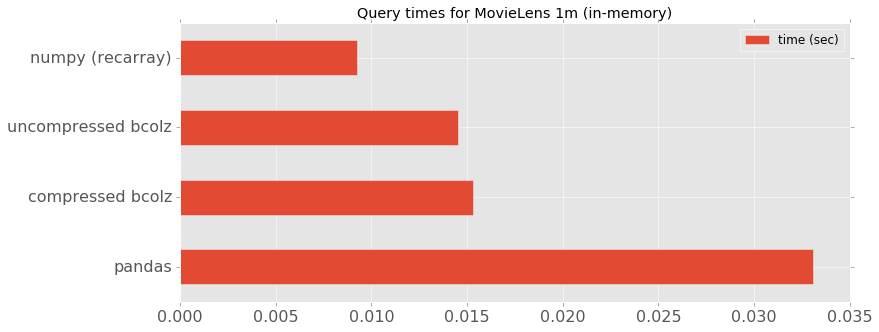

In [43] used 5.508 MiB RAM in 0.186s, peaked 0.000 MiB above current, total RAM usage 1259.891 MiB


In [43]:
# Query times
labels = ["pandas", "compressed bcolz", "uncompressed bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_ubcolz, qtime_numpy]}, index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

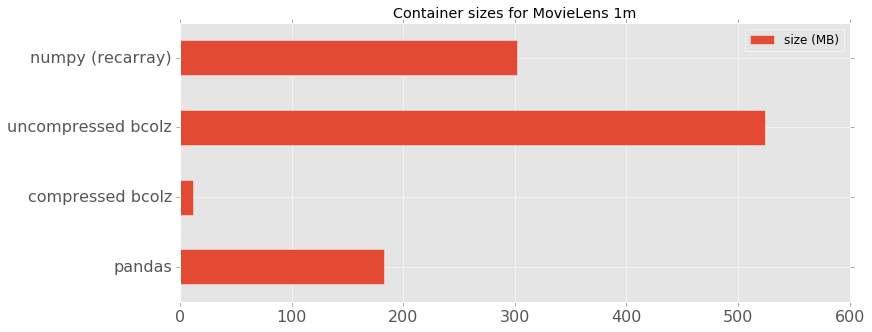

In [44] used 0.504 MiB RAM in 0.179s, peaked 0.000 MiB above current, total RAM usage 1260.395 MiB


In [44]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas2, size_bcolz2, size_ubcolz2, size_numpy3]}, index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)